In [1]:
# Cell 1 - Importing Libraries
import numpy as np
import pandas as pd
from pathlib import Path
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


In [2]:
# Cell 2 - Load and Prepare Dataset
image_dir = Path(r"C:\NEMO\3. Augmentation")  # Update this to your directory path

# Get filepaths and labels
filepaths = list(image_dir.rglob('*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1].replace(" Masked", ""), filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Sample 200 images from each class (adjust as necessary)
samples = []
for category in image_df['Label'].unique():
    category_slice = image_df.query("Label == @category")
    samples.append(category_slice.sample(200, random_state=1))

image_df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)


In [5]:
# Cell 3 - Split Data and Define Generators
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

# Define different target sizes for compatibility with different models
target_sizes = {
    'small': (224, 224),
    'large': (299, 299)
}

# Define generators with different preprocessing functions and target sizes
train_generator_small = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

train_generator_large = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
    validation_split=0.2
)

# Validation and Test Generators
val_generator_small = train_generator_small.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=target_sizes['small'],
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

val_generator_large = train_generator_large.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=target_sizes['large'],
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

# Test Generators
test_generator_small = train_generator_small.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=target_sizes['small'],
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

test_generator_large = train_generator_large.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=target_sizes['large'],
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


Found 588 validated image filenames belonging to 21 classes.
Found 588 validated image filenames belonging to 21 classes.
Found 1260 validated image filenames belonging to 21 classes.
Found 1260 validated image filenames belonging to 21 classes.


In [6]:
# Cell 4 - Define the Models
def create_model(base_model, num_classes):
    base_model.trainable = False  # Freeze the base model weights
    inputs = base_model.input
    
    # Add global pooling layer to flatten the output of the base model
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    
    # Add fully connected layers
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    
    # Output layer with the number of classes and softmax activation
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Define the number of classes for classification
num_classes = 21

# Initialize models
models = {
    'MobileNetV2': create_model(tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet'), num_classes),
    'EfficientNetB0': create_model(tf.keras.applications.EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet'), num_classes),
    'NASNetMobile': create_model(tf.keras.applications.NASNetMobile(input_shape=(224, 224, 3), include_top=False, weights='imagenet'), num_classes),
    'ResNet50': create_model(tf.keras.applications.ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet'), num_classes),
    'InceptionV3': create_model(tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights='imagenet'), num_classes),
    'DenseNet121': create_model(tf.keras.applications.DenseNet121(input_shape=(224, 224, 3), include_top=False, weights='imagenet'), num_classes),
    'VGG16': create_model(tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet'), num_classes),
    'Xception': create_model(tf.keras.applications.Xception(input_shape=(299, 299, 3), include_top=False, weights='imagenet'), num_classes)
}

# Training each model with respective generators based on input size
histories = {}
results = {}
for model_name, model_instance in models.items():
    print(f"\nTraining {model_name}...")

    # Choose appropriate generators
    if model_name in ['InceptionV3', 'Xception']:
        train_images = train_generator_large.flow_from_dataframe(
            dataframe=train_df,
            x_col='Filepath',
            y_col='Label',
            target_size=(299, 299),
            class_mode='categorical',
            batch_size=32,
            subset='training'
        )
        val_images = val_generator_large
        test_images = test_generator_large
    else:
        train_images = train_generator_small.flow_from_dataframe(
            dataframe=train_df,
            x_col='Filepath',
            y_col='Label',
            target_size=(224, 224),
            class_mode='categorical',
            batch_size=32,
            subset='training'
        )
        val_images = val_generator_small
        test_images = test_generator_small

    # Compile the model before training
    model_instance.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model
    history = model_instance.fit(
        train_images,
        validation_data=val_images,
        epochs=100,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=3,
                restore_best_weights=True
            )
        ]
    )

    # Store history and evaluate the model
    histories[model_name] = {
        'train_accuracy': history.history['accuracy'],
        'val_accuracy': history.history['val_accuracy']
    }
    results[model_name] = model_instance.evaluate(test_images, verbose=0)
    print(f"{model_name} Test Accuracy: {results[model_name][1] * 100:.2f}%")



# Now proceed with model training as you did before



Training MobileNetV2...
Found 2352 validated image filenames belonging to 21 classes.
Epoch 1/100
74/74 [==============================] - 12s 104ms/step - loss: 1.4105 - accuracy: 0.6131 - val_loss: 0.5556 - val_accuracy: 0.8401
Epoch 2/100
74/74 [==============================] - 6s 81ms/step - loss: 0.3232 - accuracy: 0.9111 - val_loss: 0.2659 - val_accuracy: 0.9252
Epoch 3/100
74/74 [==============================] - 6s 81ms/step - loss: 0.1363 - accuracy: 0.9728 - val_loss: 0.1752 - val_accuracy: 0.9456
Epoch 4/100
74/74 [==============================] - 6s 82ms/step - loss: 0.0849 - accuracy: 0.9800 - val_loss: 0.1544 - val_accuracy: 0.9541
Epoch 5/100
74/74 [==============================] - 6s 83ms/step - loss: 0.0454 - accuracy: 0.9932 - val_loss: 0.1497 - val_accuracy: 0.9541
Epoch 6/100
74/74 [==============================] - 6s 82ms/step - loss: 0.0321 - accuracy: 0.9928 - val_loss: 0.1188 - val_accuracy: 0.9643
Epoch 7/100
74/74 [==============================] - 6s 81m

In [7]:
# Cell 5 - Convert to TFLite and Measure Size
def convert_to_tflite(model, model_name):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    tflite_dir = Path(r"C:\NEMO\Different Models")
    tflite_path = tflite_dir / f"{model_name}.tflite"  # Using Path to create the file path
    with open(tflite_path, "wb") as f:
        f.write(tflite_model)
    print(f"{model_name} converted to TFLite.")
    tflite_size = os.path.getsize(tflite_path) / 1024  # Size in KB
    return tflite_size

tflite_sizes = {name: convert_to_tflite(model, name) for name, model in models.items()}


INFO:tensorflow:Assets written to: C:\Users\manve\AppData\Local\Temp\tmpjgg1_2yh\assets


INFO:tensorflow:Assets written to: C:\Users\manve\AppData\Local\Temp\tmpjgg1_2yh\assets


MobileNetV2 converted to TFLite.


INFO:tensorflow:Assets written to: C:\Users\manve\AppData\Local\Temp\tmp8bmydvn3\assets


INFO:tensorflow:Assets written to: C:\Users\manve\AppData\Local\Temp\tmp8bmydvn3\assets


EfficientNetB0 converted to TFLite.


INFO:tensorflow:Assets written to: C:\Users\manve\AppData\Local\Temp\tmpfm3qrmbm\assets


INFO:tensorflow:Assets written to: C:\Users\manve\AppData\Local\Temp\tmpfm3qrmbm\assets


NASNetMobile converted to TFLite.


INFO:tensorflow:Assets written to: C:\Users\manve\AppData\Local\Temp\tmpjbm3mvjq\assets


INFO:tensorflow:Assets written to: C:\Users\manve\AppData\Local\Temp\tmpjbm3mvjq\assets


ResNet50 converted to TFLite.


INFO:tensorflow:Assets written to: C:\Users\manve\AppData\Local\Temp\tmp2h2z8gj9\assets


INFO:tensorflow:Assets written to: C:\Users\manve\AppData\Local\Temp\tmp2h2z8gj9\assets


InceptionV3 converted to TFLite.


INFO:tensorflow:Assets written to: C:\Users\manve\AppData\Local\Temp\tmpd0odl1qi\assets


INFO:tensorflow:Assets written to: C:\Users\manve\AppData\Local\Temp\tmpd0odl1qi\assets


DenseNet121 converted to TFLite.


INFO:tensorflow:Assets written to: C:\Users\manve\AppData\Local\Temp\tmp9i0oq_06\assets


INFO:tensorflow:Assets written to: C:\Users\manve\AppData\Local\Temp\tmp9i0oq_06\assets


VGG16 converted to TFLite.


INFO:tensorflow:Assets written to: C:\Users\manve\AppData\Local\Temp\tmpi85cmlyr\assets


INFO:tensorflow:Assets written to: C:\Users\manve\AppData\Local\Temp\tmpi85cmlyr\assets


Xception converted to TFLite.


In [8]:
# Cell 6 - Display Metrics for Comparison
metrics_df = pd.DataFrame({
    "Model": list(results.keys()),
    "Test Loss": [results[model_name][0] for model_name in results],
    "Test Accuracy (%)": [results[model_name][1] * 100 for model_name in results],
    "TFLite Model Size (KB)": list(tflite_sizes.values())
})

print(metrics_df)

            Model  Test Loss  Test Accuracy (%)  TFLite Model Size (KB)
0     MobileNetV2   0.063878          97.619045             9367.117188
1  EfficientNetB0   3.045447           3.968254            16367.937500
2    NASNetMobile   0.174259          95.317459            17281.035156
3        ResNet50   1.383124          60.555553            92859.632812
4     InceptionV3   0.134451          95.476192            86185.351562
5     DenseNet121   0.099730          96.904761            27825.937500
6           VGG16   0.215547          93.253970            57820.757812
7        Xception   0.143617          95.793653            82324.445312


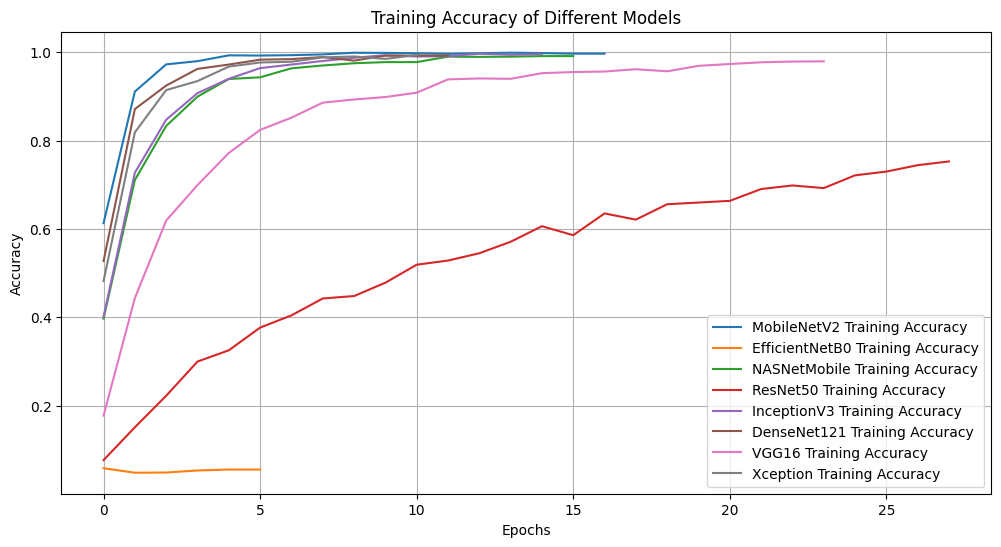

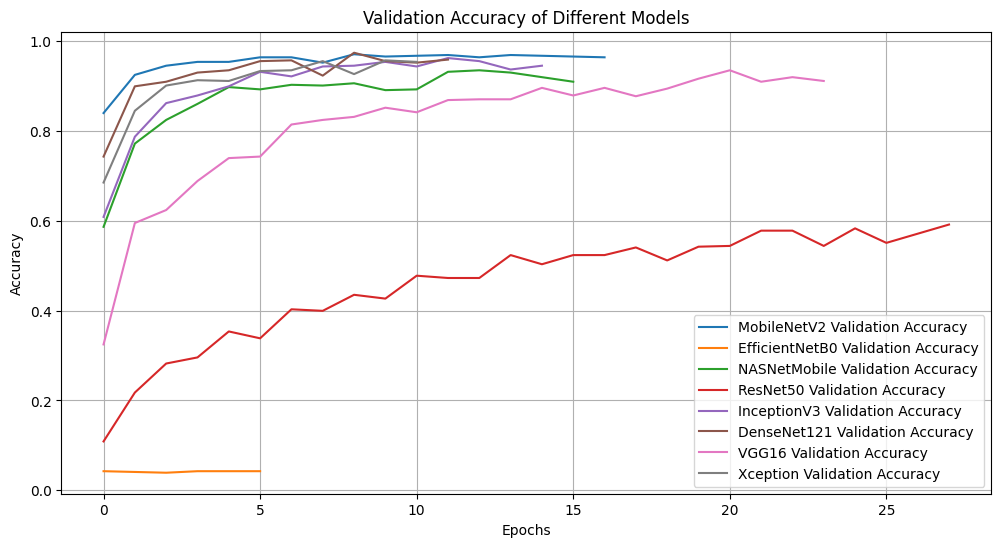

In [11]:
# Cell 8 - Visualize Training and Validation Accuracy
# Plot Training Accuracy
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
for model_name, model_history in histories.items():
    plt.plot(model_history['train_accuracy'], label=f'{model_name} Training Accuracy')
plt.title('Training Accuracy of Different Models')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot Validation Accuracy
plt.figure(figsize=(12, 6))
for model_name, model_history in histories.items():
    plt.plot(model_history['val_accuracy'], label=f'{model_name} Validation Accuracy')
plt.title('Validation Accuracy of Different Models')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

<Figure size 1000x600 with 0 Axes>

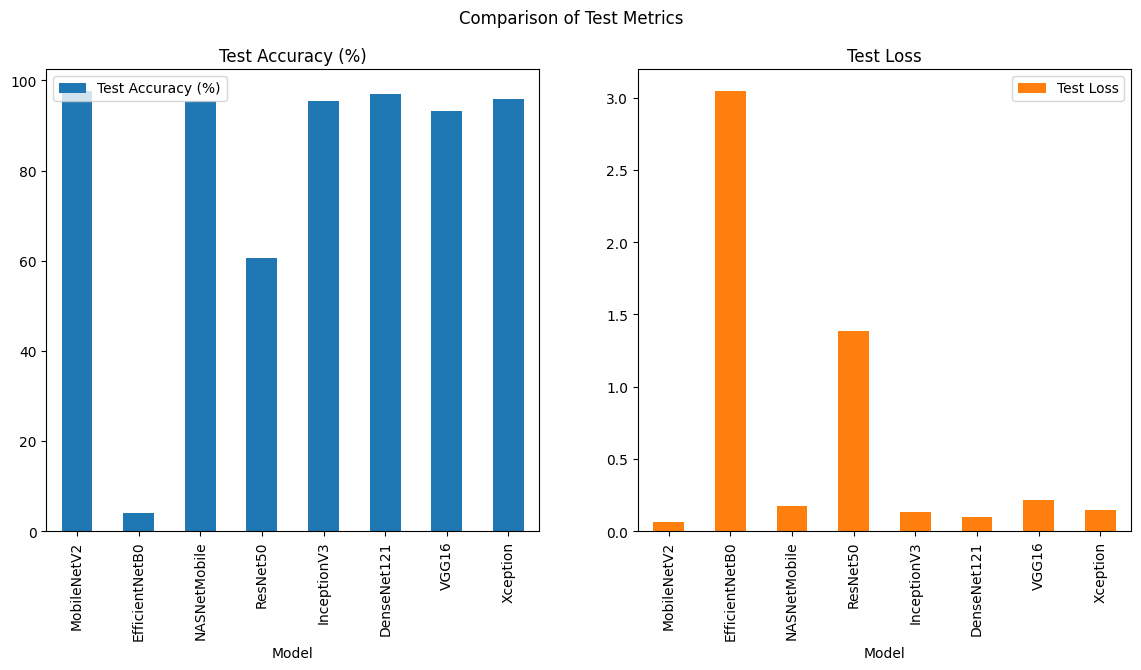

In [12]:
# Cell 9 - Visualize Test Results for Each Model
plt.figure(figsize=(10, 6))
metrics_df.plot(x='Model', y=['Test Accuracy (%)', 'Test Loss'], kind='bar', subplots=True, layout=(1, 2), figsize=(14, 6))
plt.suptitle('Comparison of Test Metrics')
plt.show()


In [19]:
# Cell 10 - Inference Time Comparison (Optional - Run on Device)
import time
import pandas as pd
import numpy as np
import tensorflow as tf

# Function to measure inference time for a given model and dataset
def measure_inference_time(model, test_generator, n=10, batch_size=1):
    start_time = time.time()
    
    for _ in range(n):
        # Get a batch of images from the generator
        images, _ = next(test_generator)  # Fetch a batch; this returns a tuple (images, labels)
        
        # Use only a subset of images if batch size is larger than 1
        if images.shape[0] > batch_size:
            images = images[:batch_size]  # Limit to the first image

        # Run prediction for the batch
        _ = model.predict(images)  # Run prediction

    avg_time = (time.time() - start_time) / n  # Calculate average time per inference
    return avg_time * 1000  # Convert to milliseconds

# Measure inference time for each model
inference_times = {}
for model_name, model_instance in models.items():
    print(f"Measuring inference time for {model_name}...")

    # Use appropriate test generator based on model input size
    if model_name in ['InceptionV3', 'Xception']:
        current_test_images = test_generator_large  # 299x299 images for InceptionV3 and Xception
    else:
        current_test_images = test_generator_small  # 224x224 images for other models

    # Measure inference time with a smaller batch size
    inference_times[model_name] = measure_inference_time(model_instance, current_test_images, batch_size=1)

# Convert results to a DataFrame and include inference times
metrics_df = pd.DataFrame({
    "Model": list(results.keys()),
    "Test Accuracy (%)": [results[model_name][1] * 100 for model_name in results.keys()],
    "Avg Inference Time (ms)": [inference_times[model_name] for model_name in results.keys()]
})

# Display the DataFrame with metrics
print(metrics_df)


Measuring inference time for MobileNetV2...
1/1 [==============================] - 0s 26ms/step
Measuring inference time for EfficientNetB0...
1/1 [==============================] - 0s 25ms/step
Measuring inference time for NASNetMobile...
1/1 [==============================] - 0s 42ms/step
Measuring inference time for ResNet50...
1/1 [==============================] - 0s 20ms/step
Measuring inference time for InceptionV3...
1/1 [==============================] - 0s 31ms/step
Measuring inference time for DenseNet121...
1/1 [==============================] - 0s 31ms/step
Measuring inference time for VGG16...
1/1 [==============================] - 0s 28ms/step
Measuring inference time for Xception...
1/1 [==============================] - 0s 21ms/step
            Model  Test Accuracy (%)  Avg Inference Time (ms)
0     MobileNetV2          97.619045               177.193284
1  EfficientNetB0           3.968254               154.156351
2    NASNetMobile          95.317459               171